In [1]:
%load_ext autoreload

In [2]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from Model import Model
from TestModel import TestModel
from flaml import AutoML

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

In [3]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments


In [4]:
apartments_test = preprocessor.apartments_test
buildings = preprocessor.buildings
buildings_test = preprocessor.buildings_test
merged = preprocessor.merged.copy()
merged_test = preprocessor.merged_test.copy()
labels = merged["price"]
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


In [5]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

In [6]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


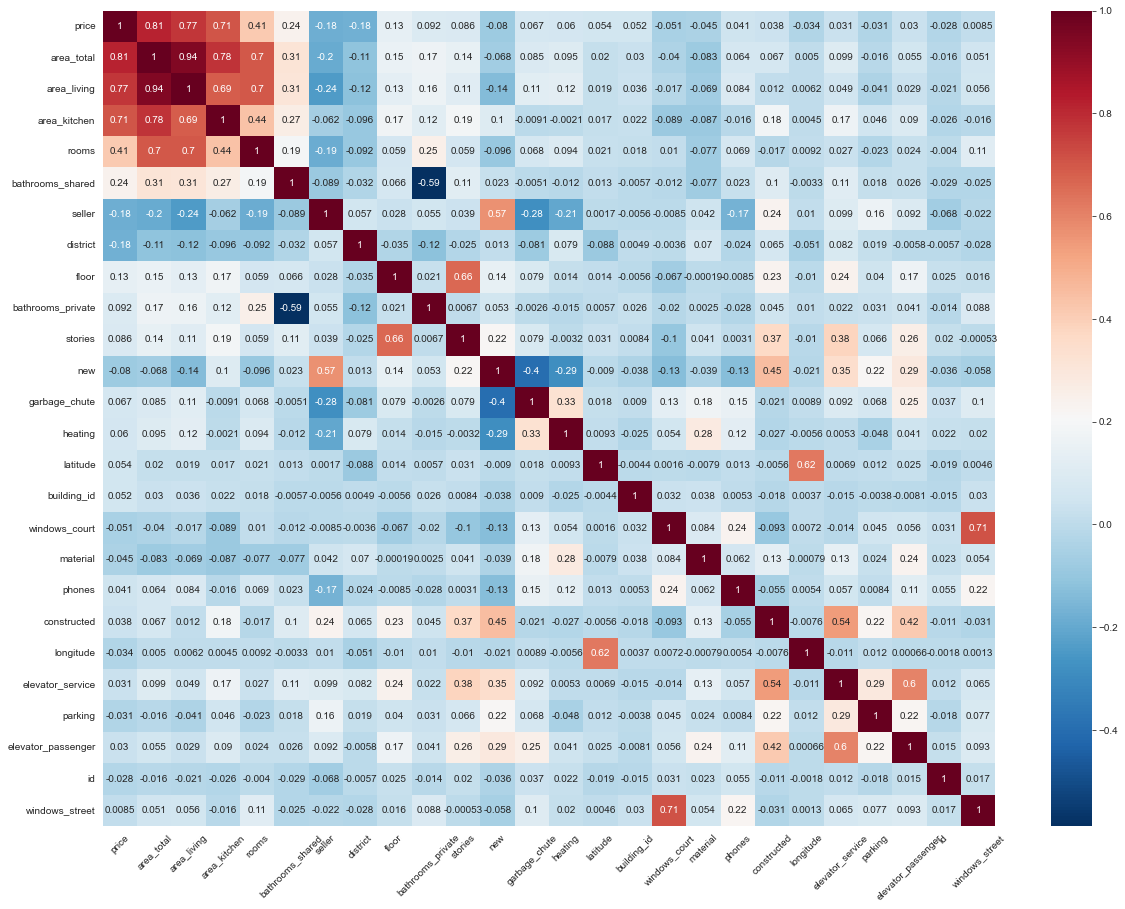

In [7]:
visualizer.price_correlation(data)

In [8]:
data = preprocessor.logify(data.copy(), "price")
data = preprocessor.logify(data.copy(), "area_total")
data = preprocessor.logify(data.copy(), "area_living")
data = preprocessor.remove_zero_values(data.copy(), "area_living")
data = preprocessor.logify(data.copy(), "area_kitchen")
data.shape

(33222, 26)

In [9]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)

,seller,price,area_total,latitude,longitude,district,material,parking,heating,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,has_elevator,scaled_constructed,floor_stories
0,3.0,15.781156,4.097672,55.544046,37.478055,11.0,3.0,1.0,-1.0,2.048836,1.329798,0.635163,2.0,10.127554,2,7.611842,0.248849
1,-1.0,16.166886,4.488636,55.861282,37.666647,2.0,3.0,1.0,0.0,1.496212,1.379852,0.606263,2.0,9.414752,2,7.249926,1.054433
2,3.0,16.014916,4.375757,55.663299,37.515335,6.0,3.0,1.0,-1.0,1.458586,1.346878,0.721475,2.0,9.397743,2,7.611842,1.225541
3,-1.0,16.166886,4.488636,55.861282,37.666647,2.0,3.0,1.0,0.0,1.496212,1.379852,0.603312,2.0,9.414752,2,7.249926,1.054433
4,-1.0,16.447399,4.369448,55.590785,37.451438,11.0,2.0,1.0,0.0,2.184724,1.270797,0.661496,1.0,9.954313,2,7.253400,0.594670


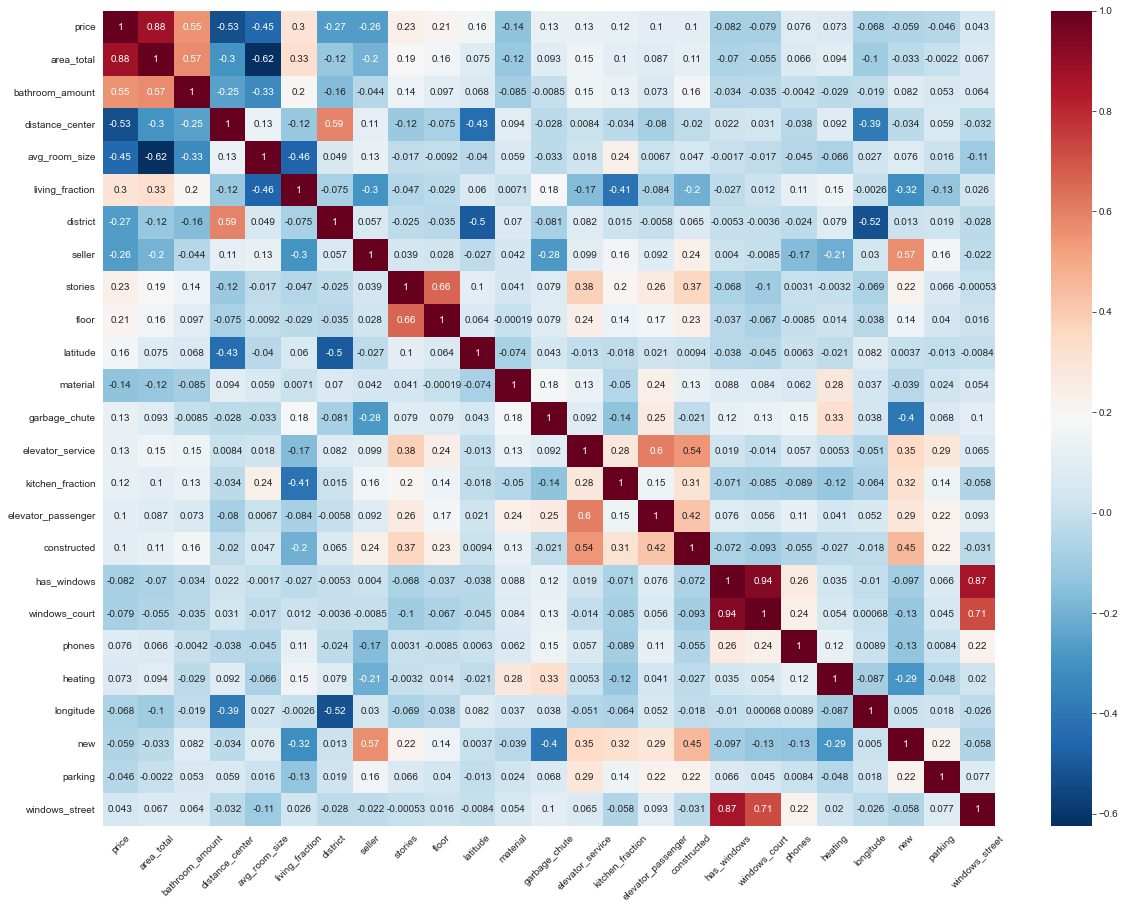

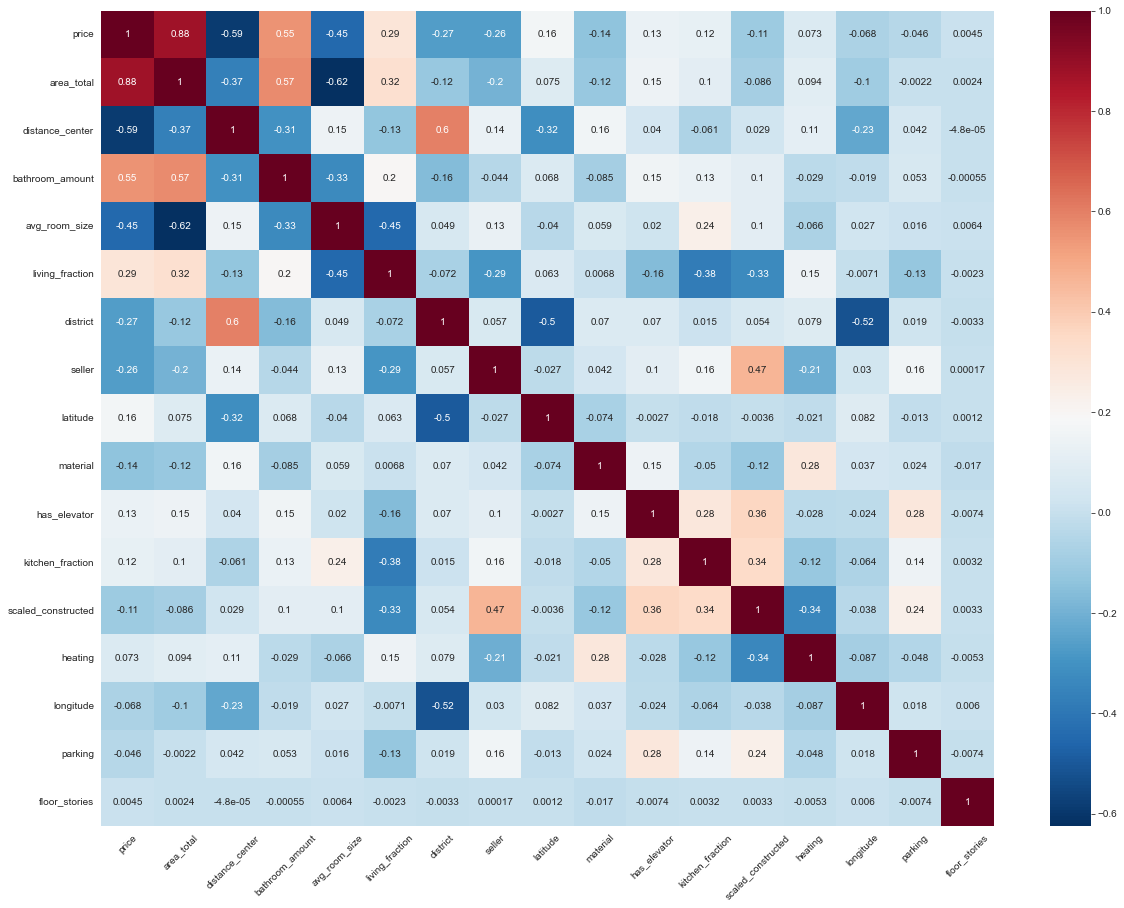

In [10]:
featured = preprocessor.combine_area_rooms(removed_outliers.copy())

featured = preprocessor.remove_labels(featured.copy(), ["area_living", "area_kitchen", "rooms"])

featured = preprocessor.combine_baths(featured.copy())
featured = preprocessor.remove_labels(featured.copy(), labels=["bathrooms_private", "bathrooms_shared"])
featured = preprocessor.combine_windows(featured.copy())
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
featured = preprocessor.combine_latlon(featured.copy())

featured = preprocessor.remove_labels(featured.copy(), ["id", "building_id"])

visualizer.price_correlation(featured)

featured = preprocessor.remove_labels(featured.copy(), ["garbage_chute", "phones", "has_windows", "windows_street", "windows_court"])

featured = preprocessor.combine_elevators(featured.copy())
featured = preprocessor.remove_labels(featured.copy(), ["elevator_passenger", "elevator_service"])
featured = preprocessor.redo_new(featured.copy())

featured = preprocessor.combine_new_constructed_distance(featured.copy())
featured = preprocessor.remove_labels(featured.copy(), ["constructed", "new"])

featured = preprocessor.combine_floor_stories(featured.copy())
featured = preprocessor.remove_labels(featured.copy(), ["floor", "stories"])

featured = preprocessor.logify(featured.copy(),"scaled_constructed")
featured = preprocessor.logify(featured.copy(),"distance_center")
featured = preprocessor.logify(featured.copy(),"lat")
featured = preprocessor.logify(featured.copy(),"long")
featured = preprocessor.logify(featured.copy(),"living_fraction",True)
featured = preprocessor.logify(featured.copy(),"floor_stories",True)
visualizer.price_correlation(featured)
categorical = preprocessor.split_categorical_features(featured.copy(), ["seller", "district", "material", "has_elevator"])
featured.head()

In [11]:
# Seperating training and test data
train_data = categorical[:23285].copy()
labels = train_data["price"]
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.01)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

print("Fitting model...")
model = TestModel(x_train, y_train)
pipeline = model.fit()
test_pred = np.round([np.expm1(pred) for pred in model.predict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in model.predict(test_data)]
model.save_predictions(pred)

Split data into train and test
Validation data created and price dropped
The number of features are now: 37
Fitting model...
Fitting complete
RMLSE: 0.12639659772959072


,id,price_prediction
0,23285,27686712.0
1,23286,8590556.0
2,23287,6317935.0
3,23288,10100847.0
4,23289,5117771.0
...,...,...
9932,33217,29278604.0
9933,33218,19328992.0
9934,33219,9556762.0
9935,33220,10332791.0


In [ ]:
automl_model = TestModel(x_train, y_train)
automl_model.autoMLfit(x_train, y_train, ["lgbm","xgboost","catboost"])

#automl = AutoML()
#automl.fit(x_train, y_train, task="regression", estimator_list=["xgboost"])

[flaml.automl: 11-13 15:57:08] {1485} INFO - Data split method: uniform
[flaml.automl: 11-13 15:57:08] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-13 15:57:08] {1540} INFO - Minimizing error metric: 1-r2
[flaml.automl: 11-13 15:57:08] {1577} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl: 11-13 15:57:08] {1826} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-13 15:57:08] {1943} INFO - Estimated sufficient time budget=650s. Estimated necessary time budget=1s.
[flaml.automl: 11-13 15:57:08] {2023} INFO -  at 0.4s,	estimator lgbm's best error=0.5744,	best estimator lgbm's best error=0.5744
[flaml.automl: 11-13 15:57:08] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-13 15:57:08] {2023} INFO -  at 0.5s,	estimator lgbm's best error=0.5744,	best estimator lgbm's best error=0.5744
[flaml.automl: 11-13 15:57:08] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-13 15:57:08] {2023} INFO -  at 0

In [13]:
test_pred = np.round([np.expm1(pred) for pred in automl_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % automl_model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in automl_model.predict(test_data)]
automl_model.save_predictions(pred)
automl_model.autoML_print_best_model()
#print(automl.predict(x_test))

#print(automl.model.estimator)

Fitting complete
RMLSE: 0.13681343236608295
LGBMRegressor(colsample_bytree=0.5228904456290556,
              learning_rate=0.07373980953120383, max_bin=1023,
              min_child_samples=4, n_estimators=459, num_leaves=173,
              reg_alpha=0.0009765625, reg_lambda=1.3846194726187449,
              verbose=-1)
